In [1]:
from carbon import CarbonPair, CarbonSimulatorUI, analytics as al
from carbon import __version__ as cversion
import numpy as np
from matplotlib import pyplot as plt
from collections import namedtuple
print (f"Carbon Version v{cversion}")
print (f"Analytics Version v{al.__version__}")

Carbon Version v1.1 beta
Analytics Version v1.0 beta2-2


# Carbon Simulation - Demo 3-2

In this demo we look at an **order book**

## Setup

In [2]:
Sim = CarbonSimulatorUI(pair=CarbonPair("ETH","USDC"), verbose=False, raiseonerror=True)
CA = al.Analytics(Sim, verbose=True)
CA

Analytics(sim=CarbonSimulatorUI(<0 orders, 0 trades>, pair='CarbonPair(tknb='ETH', tknq='USDC')'))

In [3]:
orders = tuple(
    al.orders_nt("ETH", 10, 2000, 2000+x*25) for x in range(21)
)
orders[:2]

(orders_nt(tkn='ETH', amt=10, p_start=2000, p_end=2000),
 orders_nt(tkn='ETH', amt=10, p_start=2000, p_end=2025))

In [4]:
maxx = 3000
orders = tuple([
    al.orders_nt("ETH", 100, 2000, maxx),
    al.orders_nt("ETH", 100, 2500, 2700),
    #al.orders_nt("ETH", 100, 2200, 2600),
    al.orders_nt("USDC", 1000*100, 1500, 500),
    al.orders_nt("USDC", 1100*100, 1200, 1000),
])

In [5]:
for o in orders:
    Sim.add_order(o.tkn, o.amt, o.p_start, o.p_end)
Sim.state()["orders"]

,id,pair,tkn,y_int,y,y_unit,p_start,p_end,p_marg,p_unit,lid
0,0,ETHUSDC,ETH,100.0,100.0,ETH,2000.0,3000.0,2000.0,USDC per ETH,0
1,1,ETHUSDC,ETH,100.0,100.0,ETH,2500.0,2700.0,2500.0,USDC per ETH,1
2,2,ETHUSDC,USDC,100000.0,100000.0,USDC,1500.0,500.0,1500.0,USDC per ETH,2
3,3,ETHUSDC,USDC,110000.0,110000.0,USDC,1200.0,1000.0,1200.0,USDC per ETH,3


In [6]:
Sim.liquidity(Sim.ASDF)

y
pair    tkn           
ETHUSDC ETH      200.0
        USDC  210000.0

## AMM sells base token (ask side)

In [7]:
max_liquidity = Sim.liquidity()["ETHUSDC"]["ETH"]
print("max liquidity", max_liquidity)
src_amounts = al.linspace(max_liquidity, 20)

max liquidity 200.0


In [8]:
CA.simulate_trades(60, CA.ASK)

[simulate_trades] trading src=60 trg=134820.376915 [pair=ETHUSDC, tknb=ETH amm_sells_tknb]


134820.376915

In [9]:
CA.simulate_trades(70, CA.ASK)

[simulate_trades] trading src=70 trg=159939.922511 [pair=ETHUSDC, tknb=ETH amm_sells_tknb]


159939.922511

In [10]:
trg_amounts = al.vec([
    CA.simulate_trades(size, CA.ASK) for size in src_amounts
])

[simulate_trades] trading src=0.0001 trg=0.2 [pair=ETHUSDC, tknb=ETH amm_sells_tknb]
[simulate_trades] trading src=10.0 trg=20373.867433 [pair=ETHUSDC, tknb=ETH amm_sells_tknb]
[simulate_trades] trading src=20.0 trg=41523.95764 [pair=ETHUSDC, tknb=ETH amm_sells_tknb]
[simulate_trades] trading src=30.0 trg=63495.491961 [pair=ETHUSDC, tknb=ETH amm_sells_tknb]
[simulate_trades] trading src=40.0 trg=86337.273988 [pair=ETHUSDC, tknb=ETH amm_sells_tknb]
[simulate_trades] trading src=50.0 trg=110102.051443 [pair=ETHUSDC, tknb=ETH amm_sells_tknb]
[simulate_trades] trading src=60.0 trg=134820.376915 [pair=ETHUSDC, tknb=ETH amm_sells_tknb]
[simulate_trades] trading src=70.0 trg=159939.922511 [pair=ETHUSDC, tknb=ETH amm_sells_tknb]
[simulate_trades] trading src=80.0 trg=185220.80176 [pair=ETHUSDC, tknb=ETH amm_sells_tknb]
[simulate_trades] trading src=90.0 trg=210664.573951 [pair=ETHUSDC, tknb=ETH amm_sells_tknb]
[simulate_trades] trading src=100.0 trg=236272.81853 [pair=ETHUSDC, tknb=ETH amm_sel

In [11]:
OB = al.OrderBook(src_amounts, trg_amounts, "ETH", "USDC")
print(OB.explain())

Source token = ETH, target token = USDC.
AMM sells ETH for USDC.
Prices are quoted in USDC per ETH.
Order book amounts are quoted in ETH.


'plotted tokens received against trade size (504,750)'

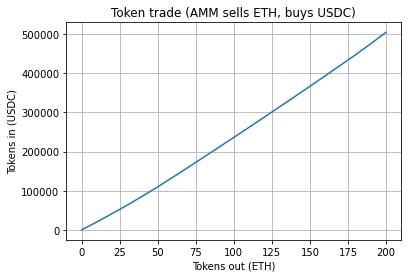

In [12]:
OB.plot_token_amount_chart()

When SELLING ETH, the AMM sells more and more expensively the more ETH it sells

'plotted marginal and effective prices against trade size'

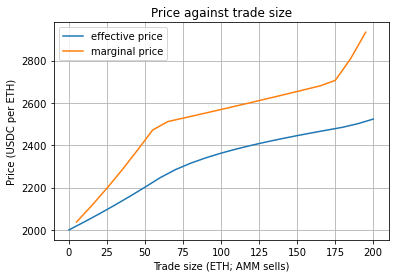

In [13]:
OB.plot_price_chart()

When SELLING ETH, the AMM pays more (in ETH terms) for the first units of USD received than for the later ones

'plotted order book (479,896)'

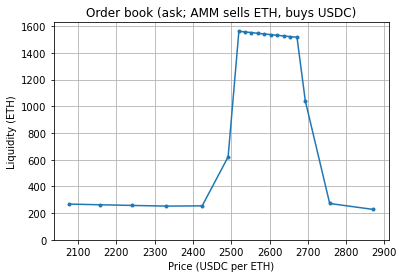

In [14]:
OB.plot_orderbook_chart()

## AMM sells base token (bid side)

In [15]:
trg_amounts = al.vec([
    CA.simulate_trades(size, CA.BID) for size in src_amounts
])

[simulate_trades] trading src=0.0001 trg=0.15 [pair=ETHUSDC, tknb=ETH amm_buys_tknb]
[simulate_trades] trading src=10.0 trg=14105.7324 [pair=ETHUSDC, tknb=ETH amm_buys_tknb]
[simulate_trades] trading src=20.0 trg=26635.218165 [pair=ETHUSDC, tknb=ETH amm_buys_tknb]
[simulate_trades] trading src=30.0 trg=38511.693914 [pair=ETHUSDC, tknb=ETH amm_buys_tknb]
[simulate_trades] trading src=40.0 trg=50198.117777 [pair=ETHUSDC, tknb=ETH amm_buys_tknb]
[simulate_trades] trading src=50.0 trg=61699.015466 [pair=ETHUSDC, tknb=ETH amm_buys_tknb]
[simulate_trades] trading src=60.0 trg=73018.770133 [pair=ETHUSDC, tknb=ETH amm_buys_tknb]
[simulate_trades] trading src=70.0 trg=84161.627932 [pair=ETHUSDC, tknb=ETH amm_buys_tknb]
[simulate_trades] trading src=80.0 trg=95131.703339 [pair=ETHUSDC, tknb=ETH amm_buys_tknb]
[simulate_trades] trading src=90.0 trg=105932.984209 [pair=ETHUSDC, tknb=ETH amm_buys_tknb]
[simulate_trades] trading src=100.0 trg=116569.336615 [pair=ETHUSDC, tknb=ETH amm_buys_tknb]
[sim

In [16]:
OB2 = al.OrderBook(src_amounts, trg_amounts, "ETH", "USDC", bidask=al.OrderBook.BID)
print(OB2.explain())

Source token = ETH, target token = USDC.
AMM buys ETH for USDC.
Prices are quoted in USDC per ETH.
Order book amounts are quoted in ETH.


'plotted tokens received against trade size (201,565)'

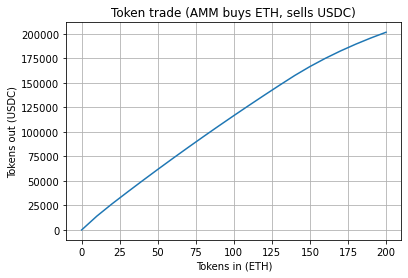

In [17]:
OB2.plot_token_amount_chart()

'plotted marginal and effective prices against trade size'

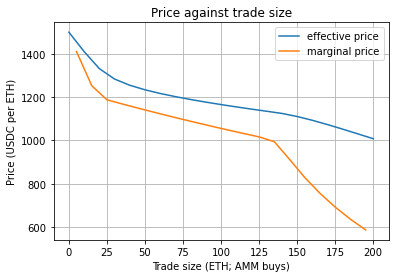

In [18]:
OB2.plot_price_chart()

'plotted order book (191,581)'

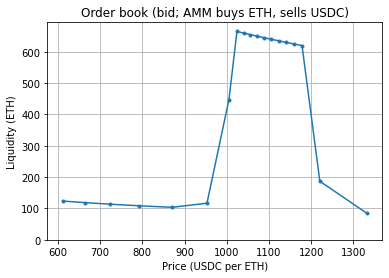

In [19]:
OB2.plot_orderbook_chart()